In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.combine import SMOTETomek

In [2]:
train_df = pd.read_csv("raw/train.csv").drop("Unnamed: 0", axis = 1)
test_df = pd.read_csv("raw/test.csv")
train_labels = pd.read_csv("raw/train_class_labels.csv").drop("Unnamed: 0", axis = 1)

<BarContainer object of 2 artists>

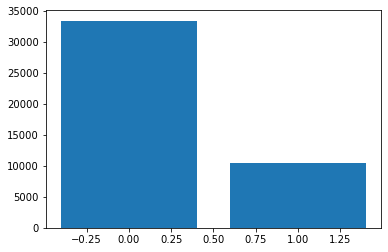

In [6]:
plt.bar(x = [0, 1], height=train_labels['income_>50K'].value_counts())

In [4]:
train_df['native-country'] = train_df['native-country'].apply(lambda x: 'Others' if x != 'United-States' else 'United-States')
test_df['native-country'] = test_df['native-country'].apply(lambda x: 'Others' if x != 'United-States' else 'United-States')

In [5]:
"""Classes for transformations"""

class RemoveOutliers(BaseEstimator, TransformerMixin):
    """Removes outliers using IQR method"""

    def __init__(self, columns = []):
        self.columns = columns

    def fit(self, df, y = None):
        return self

    def transform(self, df, y = None):
        for col_no, col in enumerate(self.columns):
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iq_range = q3 - q1
            df[col] = df[col].clip(lower = q1 - 1.5*iq_range, upper = q3 + 1.5*iq_range)
        return df

class MajorityImputer(BaseEstimator, TransformerMixin):
    """Removes outliers using IQR method"""

    def __init__(self, columns = []):
        self.columns = columns

    def fit(self, df, y = None):
        return self

    def transform(self, df, y = None):
        for i in self.columns:
            df[i] = df[i].fillna(df[i].mode())
        return df

class AddPolyFeatures(BaseEstimator, TransformerMixin):
    """Add Polynomial features"""

    def __init__(self, columns = []):
        self.columns = columns
        self.rename_dict = dict()

    def fit(self, df, y = None):
        for i in range(df.shape[1]):
            self.rename_dict[i] = "pf_" + str(i)
        return self

    def transform(self, df, y = None):
        polynomial_features = PolynomialFeatures()
        polynomial_df = polynomial_features.fit_transform(df[self.columns])
        polynomial_df = pd.DataFrame(polynomial_df).rename(self.rename_dict)
        return pd.merge(left = df, right = polynomial_df, left_index=True, right_index = True)

class MinMaxScale(BaseEstimator, TransformerMixin):
    """Normalizing Numerical Variables"""

    def __init__(self,columns=[]):
        self.columns = columns

    def fit(self, df, y = None):
        return self

    def transform(self, df, y = None):
        scaler = MinMaxScaler()
        df[self.columns] = scaler.fit_transform(df[self.columns])
        return df

class DropColumns(BaseEstimator, TransformerMixin):
    """For dropping unnecessary columns"""

    def __init__(self,columns=[]):
        self.columns = columns

    def fit(self, df, y = None):
        return self

    def transform(self, df, y = None):
        return df.drop(self.columns, axis = 1)

class OneHotEncode(BaseEstimator, TransformerMixin):
    """For One Hot Encoding categorical variables"""

    def __init__(self,columns=[]):
        self.columns = columns

    def fit(self, df, y = None):
        return self

    def transform(self,df, y = None):
        for i in self.columns:
            df[i+'i'] = df[i]
        return pd.get_dummies(df, columns = self.columns, drop_first=True)

class LabelEncode(BaseEstimator, TransformerMixin):
    """For Label Encoding Categorical Variables"""

    def __init__(self, columns = []):
        self.columns = columns
        self.encoders = []

    def fit(self, df, y = None):
        for i in self.columns:
            self.encoders.append(LabelEncoder())
        for i,col in enumerate(self.columns):
            self.encoders[i].fit(df[col])
        return self

    def transform(self, df, y = None):
        for col_no, i in enumerate(self.columns):
            df[i] = self.encoders[col_no].transform(df[i])
        return df

class AddSmote(BaseEstimator, TransformerMixin):
    """For Label Encoding Categorical Variables"""

    def __init__(self):
        self.smt = None

    def fit(self, X, y):
        return self

    def transform(self, X, y = None):
        self.smt = SMOTETomek()
        my_df = self.smt.fit_resample(X, y)
        return my_df

class Estimate(BaseEstimator, TransformerMixin):

    def __init__(self, estimator = "lg"):
        self.estimator = estimator

    def fit(self, y = None):
        return self

    def predict(self, df, y = None):
        if self.estimator == "lg":
            lr = LogisticRegression()
            lr.fit(df, y)
            return lr
        elif self.estimator == "svc":
            svc = SVC()
            svc.fit(df, y)
            return svc
        elif self.estimator == "dtc":
            dtc = DecisionTreeClassifier()
            dtc.fit(df, y)
            return dtc
        elif self.estimator == "rf":
            rf = RandomForestClassifier()
            rf.fit(df, y)
            return rf
        elif self.estimator == "knn":
            knn = KNeighborsClassifier()
            knn.fit(df, y)
            return knn
        elif self.estimator == "adt":
            adt = AdaBoostClassifier()
            adt.fit(df, y)
            return adt
        else:
            return None

In [6]:
X_t, X_v, y_t, y_v = train_test_split(train_df, train_labels['income_>50K'], test_size=0.3)

pre_pipeLine = Pipeline([
    ("remove_outliers", RemoveOutliers(columns = ["age", "fnlwgt", "hours-per-week"])),
    ("imputevalues", MajorityImputer(columns = ["occupation"])),
    ("dropper", DropColumns(columns=['education'])),
                         ("label_encoder", LabelEncode(columns=['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country'])),
                         ("minmaxscaler", MinMaxScale(columns=["age", "fnlwgt", "hours-per-week", "capital-gain", "capital-loss"]))])

# SMOTE
X_t = pre_pipeLine.fit_transform(X = X_t)
X_v = pre_pipeLine.fit_transform(X = X_v)
smt = SMOTETomek()
X_t, y_t = smt.fit_resample(X_t, y_t)
smt = SMOTETomek()
X_v, y_v = smt.fit_resample(X_v, y_v)

In [7]:
skf = StratifiedKFold(n_splits = 10)

mean_accuracy_scores = []
mean_test_accuracy_scores = []

for train_index, test_index in skf.split(X_t, y_t):

    X_train, X_test = X_t.iloc[train_index], X_t.iloc[test_index]
    y_train, y_test = y_t.iloc[train_index], y_t.iloc[test_index]

    rfc = RandomForestClassifier(max_depth = 30, min_samples_split=10)
    rfc.fit(X_train, y_train)
    mean_accuracy_scores.append(roc_auc_score(rfc.predict(X_train), y_train))
    mean_test_accuracy_scores.append(roc_auc_score(rfc.predict(X_test), y_test))

print("Mean KFold Score (Train) = ", np.mean(mean_accuracy_scores))
print("Mean KFold Score (Test) = ", np.mean(mean_test_accuracy_scores))

Mean KFold Score (Train) =  0.9599544572794679
Mean KFold Score (Test) =  0.8986730281413525


In [8]:
random_forest = RandomForestClassifier(max_depth= 30, min_samples_split=10)
random_forest.fit(X_t, y_t)
print(classification_report(random_forest.predict(X_v), y_v))
print(roc_auc_score(random_forest.predict(X_v), y_v))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      9723
           1       0.86      0.87      0.86      9607

    accuracy                           0.87     19330
   macro avg       0.87      0.87      0.87     19330
weighted avg       0.87      0.87      0.87     19330

0.8650933341324011


In [10]:
# tree explainer model
import shap
explainer = shap.TreeExplainer(random_forest)
chosen_instance = X_v.iloc[565:575]
shap_values = explainer.shap_values(chosen_instance)
shap.force_plot(explainer.expected_value[1], shap_values[1], chosen_instance)

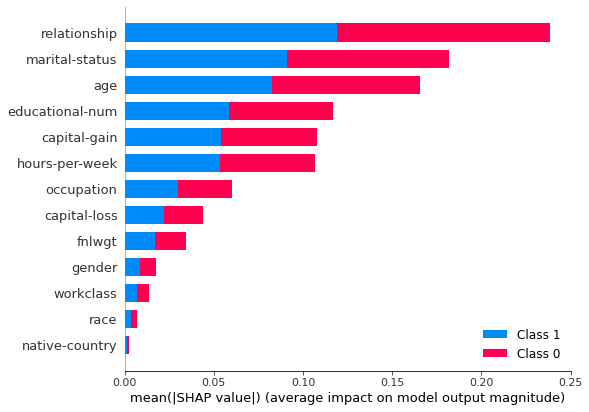

In [13]:
shap.summary_plot(shap_values, X_t.columns.to_list())